In [2]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents
try:
    %tensorflow_version 2.x
except:
    pass

Password:
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Processing /Users/lingh/Library/Caches/pip/wheels/7b/eb/1f/22c4124f3c64943aa0646daf4612b1c1f00f27d89b81304ebd/gym-0.10.11-cp37-none-any.whl
     |████████████████████████████████| 1.0 MB 1.1 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Processing /Users/lingh/Library/Caches/pip/wheels/aa/de/2f/6c5a75120d68a2c3138120c8d0ce1c6f9483a4b96307986bf2/imageio-2.4.0-py3-none-any.whl
  Using cached Pillow-7.0.0-cp37-cp37m-macosx_10_6_intel.whl (3.9 MB)
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
  Using cached pyglet-1.3.2-py2.py3-none-any.whl (1.0 MB)
  Attempting uninstall: pyglet
    Found existing installation: pygle

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

In [4]:
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common


In [6]:
tf.compat.v1.enable_v2_behavior()

In [7]:
tf.version.VERSION

'2.2.0-dev20200204'

### Hyperparameters

In [8]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### Environment

In [9]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

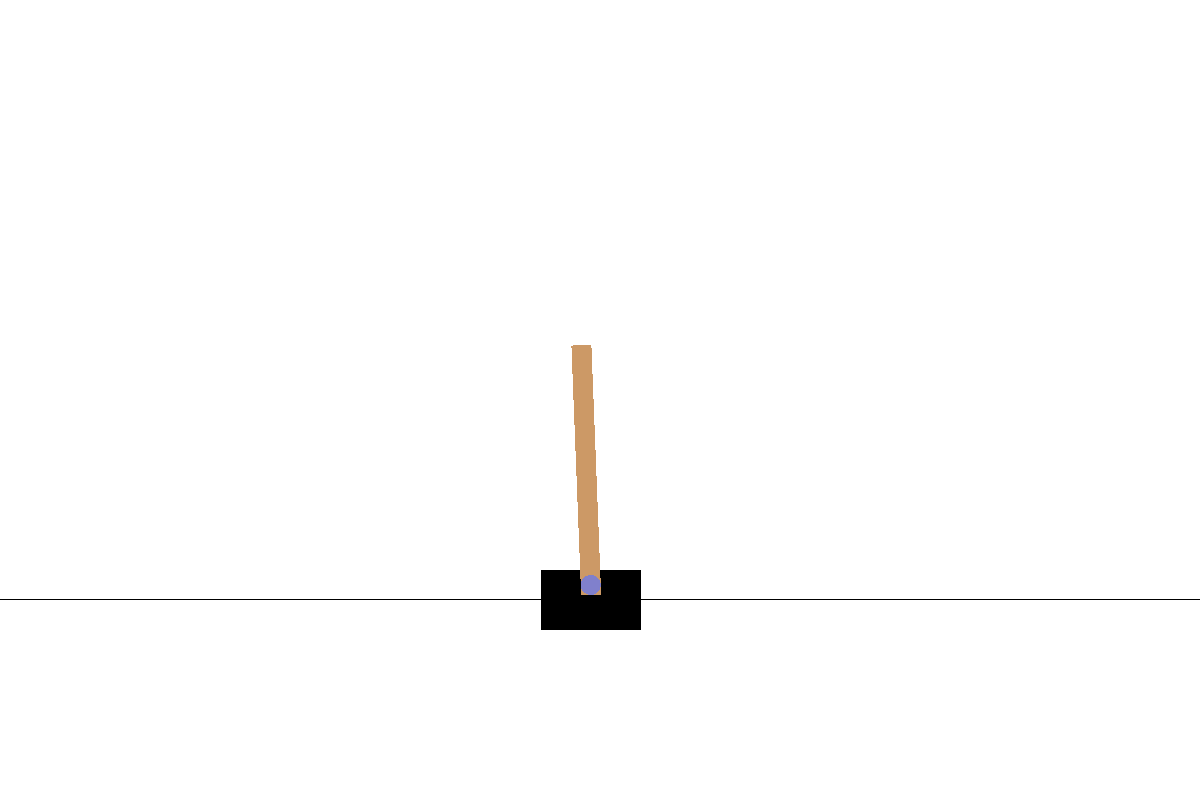

In [10]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

In [11]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [12]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [13]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In the Cartpole environment:

- observation is an array of 4 floats:
    - the position and velocity of the cart
    - the angular position and velocity of the pole
- reward is a scalar float value
- action is a scalar integer with only two possible values:
    - 0 — "move left"
    - 1 — "move right"

In [14]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = 1

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.00971075, -0.00358804, -0.01732842,  0.03368866], dtype=float32))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.00963899,  0.19177806, -0.01665465, -0.2644108 ], dtype=float32))


In [15]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [16]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### DQN 

#### Agent

In [17]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [18]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

#### Policies

In [19]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [20]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),train_env.action_spec())

To get an action from a policy, call the policy.action(time_step) method. The time_step contains the observation from the environment. This method returns a PolicyStep, which is a named tuple with three components:

    - action — the action to be taken (in this case, 0 or 1)
    - state — used for stateful (that is, RNN-based) policies
    - info — auxiliary data, such as log probabilities of actions

In [21]:
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))

In [22]:
time_step = example_environment.reset()

In [23]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

### Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.

In [24]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0
    
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
    total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [25]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

1.4

### Replay Buffer

In [26]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [27]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [28]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

### Data Collection

In [30]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    
    # Add trajectory to the replay bufferbuffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://github.com/tensorflow/agents/blob/master/tf_agents/docs/python/tf_agents/drivers.md

In [32]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [33]:
iterator = iter(dataset)

print(iterator)

### Training the agent

Two things must happen during the training loop:

- collect data from the environment
- use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [39]:
#@test {"skip": true}
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
#     experience, unused_info = next(iterator)
#     train_loss = agent.train(experience).loss

#     step = agent.train_step_counter.numpy()

#     if step % log_interval == 0:
#         print('step = {0}: loss = {1}'.format(step, train_loss))

#     if step % eval_interval == 0:
#         avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
#     print('step = {0}: Average Return = {1}'.format(step, avg_return))
#     returns.append(avg_return)

In [38]:
!python --version

Python 3.7.0
